In [2]:
import sys
sys.path.append("../../script")

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from statsmodels.discrete.discrete_model import Logit

from data_preparation import *
from utils import GridScore

# Import et préparation des données

In [3]:
train = pd.read_csv("../../data/application_train_vf.csv")

In [4]:
dataprep = DataPreparation(train, 0.3)
train_prepared = dataprep.get_prepared_data()

Variables extérieures récupérées ✅
Type des variables convertis ✅
Valeurs manquantes traitées ✅
Discrétisation des variables numériques en cours ... 


100%|██████████| 10/10 [02:59<00:00, 18.00s/it]


Variables numériques discrétisées ✅
Discrétisation des variables catégorielles en cours ... 
Variables catégorielles discrétisées ✅


In [6]:
df_train = train_prepared.iloc[:280000,:]
df_test = train_prepared.iloc[280000:,:]

In [ ]:
df_train["N"]

# Modélisation

In [31]:
features = ['AMT_CREDIT_SUM_DEBT_disc_int', 'AMT_CREDIT_SUM_disc_int', 'EXT_SOURCE_2_disc_int',  'EXT_SOURCE_1_disc_int', 'EXT_SOURCE_3_disc_int', 'NAME_INCOME_TYPE_discret', "DAYS_EMPLOYED_disc_int", ]

In [32]:
train_prepared[features]

,AMT_CREDIT_SUM_DEBT_disc_int,AMT_CREDIT_SUM_disc_int,EXT_SOURCE_2_disc_int,EXT_SOURCE_1_disc_int,EXT_SOURCE_3_disc_int,NAME_INCOME_TYPE_discret,DAYS_EMPLOYED_disc_int
0,[14643.0;334498331.21],[1024749.0;1017957917.38],[0.49;0.85],[0.46;0.96],[0.32;0.9],high_income,[-2423;365243]
1,[-6981558.21;14638.5],[0.0;1024735.5],[0.49;0.85],[0.46;0.96],[0.32;0.9],high_income,[-17912;-2424]
2,[14643.0;334498331.21],[0.0;1024735.5],[0.49;0.85],[0.15;0.46],[0.32;0.9],high_income,[-2423;365243]
3,[-6981558.21;14638.5],[0.0;1024735.5],[0.49;0.85],[0.15;0.46],[0.32;0.9],high_income,[-2423;365243]
4,[-6981558.21;14638.5],[0.0;1024735.5],[0.0;0.15],[0.0;0.15],[0.32;0.9],high_income,[-2423;365243]
...,...,...,...,...,...,...,...
306102,[14643.0;334498331.21],[1024749.0;1017957917.38],[0.0;0.15],[0.15;0.46],[0.32;0.9],Low_income,[-2423;365243]
306103,[-6981558.21;14638.5],[0.0;1024735.5],[0.49;0.85],[0.46;0.96],[0.32;0.9],high_income,[-17912;-2424]
306104,[14643.0;334498331.21],[0.0;1024735.5],[0.49;0.85],[0.46;0.96],[0.32;0.9],high_income,[-2423;365243]
306105,[14643.0;334498331.21],[0.0;1024735.5],[0.15;0.49],[0.15;0.46],[0.32;0.9],Low_income,[-2423;365243]


In [34]:
reference_categories = {
    'AMT_CREDIT_SUM_DEBT_disc_int' : "[-6981558.21;14638.5]",
    'AMT_CREDIT_SUM_disc_int' : "[1024749.0;1017957917.38]", 
    'EXT_SOURCE_2_disc_int' : "[0.49;0.85]",  
    'EXT_SOURCE_1_disc_int' : "[0.46;0.96]", 
    'EXT_SOURCE_3_disc_int' : "[0.32;0.9]", 
    'NAME_INCOME_TYPE_discret' : "Low_income", 
    'DAYS_EMPLOYED_disc_int' : '[-17912;-2424]'}

In [35]:
formula_parts = []
for var in features:
    if var in reference_categories:
        ref_category = reference_categories[var]
        formula_parts.append(f'C({var}, Treatment(reference="{ref_category}"))')

formula = 'TARGET ~ ' + ' + '.join(formula_parts)

In [36]:
model = Logit.from_formula(formula=formula, data=df_train)
logit_model = model.fit()

Optimization terminated successfully.
         Current function value: 0.248231
         Iterations 7


# Prédiction

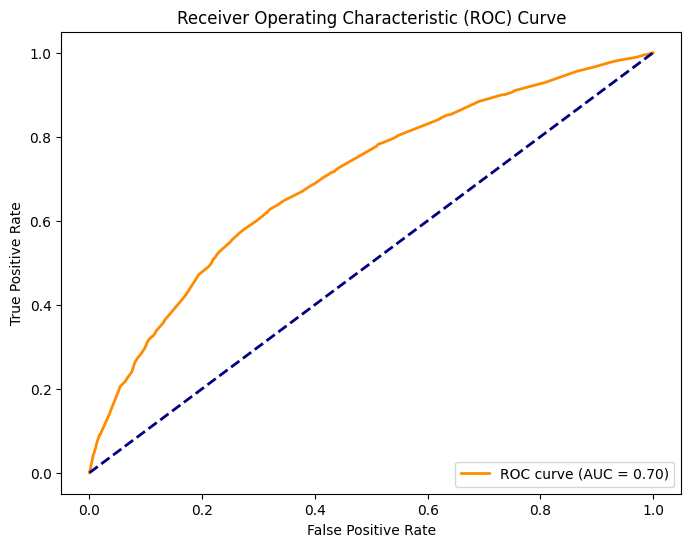

0.3989712961837035

In [37]:
pred = logit_model.predict(df_test)
fpr, tpr, thresholds = roc_curve(df_test["TARGET"],pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
roc_auc = auc(fpr, tpr)
gini_coefficient = 2 * roc_auc - 1
gini_coefficient

# Grille de score

In [38]:
GS = GridScore(train_prepared, logit_model)
grid_score = GS.compute_grid_score()

In [39]:
grid_score

,Variable,Modality,Coefficient,P-Value,Score,Contribution,Pcentage_Défaut,Pcentage_Classe
0,Intercept,-,-4.116545,0.0,0.000000,0.0,0.00,0.00
1,AMT_CREDIT_SUM_DEBT_disc_int,[-6981558.21;14638.5]_ref,0.000000,0.0,89.136490,10.0,1.50,27.25
2,AMT_CREDIT_SUM_DEBT_disc_int,[14643.0;334498331.21],0.320000,0.0,0.000000,10.0,6.18,72.75
3,AMT_CREDIT_SUM_disc_int,[1024749.0;1017957917.38]_ref,0.000000,0.0,27.855153,3.0,2.93,41.30
4,AMT_CREDIT_SUM_disc_int,[0.0;1024735.5],0.100000,0.0,0.000000,3.0,4.75,58.70
5,EXT_SOURCE_2_disc_int,[0.49;0.85]_ref,0.000000,0.0,181.058496,17.0,3.32,63.77
6,EXT_SOURCE_2_disc_int,[0.0;0.15],0.650000,0.0,0.000000,17.0,1.18,5.76
7,EXT_SOURCE_2_disc_int,[0.15;0.49],0.390000,0.0,72.423398,17.0,3.17,30.47
8,EXT_SOURCE_1_disc_int,[0.46;0.96]_ref,0.000000,0.0,231.197772,20.0,3.12,61.90
9,EXT_SOURCE_1_disc_int,[0.0;0.15],0.830000,0.0,0.000000,20.0,1.15,5.43


## Calcul des scores individuels

In [40]:
df_score = GS.get_individual_score()

(array([ 2910.,   912.,  2425.,  7352.,  5251.,  4145., 11838.,  4920.,
        24713.,  9075., 28397., 23965., 35742., 33750., 30790., 38798.,
        19442., 16819.,  3267.,  1596.]),
 array([   0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.,  400.,
         450.,  500.,  550.,  600.,  650.,  700.,  750.,  800.,  850.,
         900.,  950., 1000.]),
 <BarContainer object of 20 artists>)

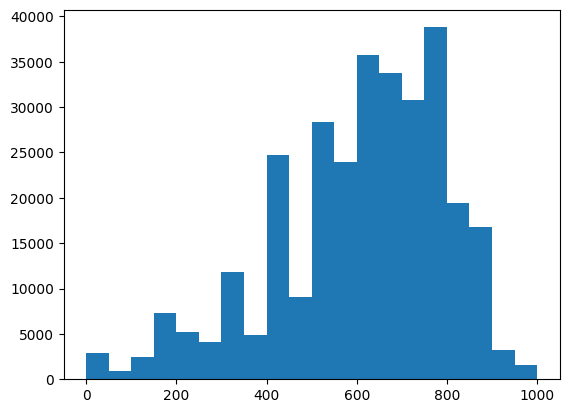

In [41]:
plt.hist(df_score["Score_ind"], bins=20)

In [42]:
df_score.to_csv("../../data/df_score_P.csv")